In [11]:
%pip install  tensorflow seaborn tensorflow_datasets

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/57.7 kB ? eta -:--:--
     ---------------------------------------- 57.7/57.7 kB ? eta 0:00:00
  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   --- ------------------------------------ 0.5/5.3 MB 14.2 MB/s eta 0:00:01
   -------- ------------------------------- 1.1/5.3 MB 13.7 MB/s eta 0:00:01
   ------------ --------------------------- 1.7/5.3 MB 13.2 MB/s eta 0:00:01
   ---------------- ----------------------- 2.2/5.3 MB 12.4 MB/s eta 0:00:01
   ------------------- -------------------- 2.6/5.3 MB 11.9 MB/s eta 0:00:01
   ----------------------- ---------------- 3.1/5.3 MB 11.5 MB/s eta 0:00:01
   ------------------------- -------------- 3.5/5.3 MB 11.0 MB/s eta 0:00:01
  

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow_datasets as tfds

In [13]:
tf.random.set_seed(42)
np.random.seed(42)
sns.set_theme()
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_1', exist_ok=True)
os.makedirs('logs', exist_ok=True)


## 1. Data Loading and Preprocessing

Training data shape: (88800, 28, 28, 1)
Test data shape: (14800, 28, 28, 1)
Number of classes: 26


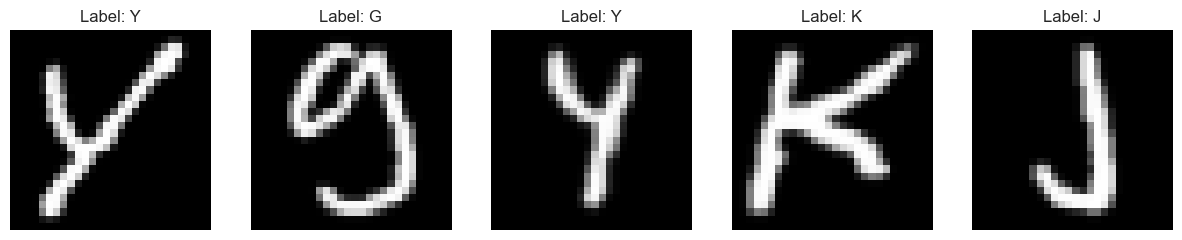

In [20]:
# Load EMNIST dataset
(ds_train, ds_test) = tfds.load('emnist/letters', split=['train', 'test'],as_supervised=True)

x_train, y_train = zip(*tfds.as_numpy(ds_train))
x_test, y_test = zip(*tfds.as_numpy(ds_test))

x_train = np.stack(x_train)
y_train = np.array(y_train)
x_test = np.stack(x_test)
y_test = np.array(y_test)

# Print dataset information
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# Plot sample images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.squeeze(x_train[i]).T, cmap='gray') 
    plt.title(f'Label: {chr(y_train[i] + 64)}') 
    plt.axis('off')
plt.show()

In [21]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for dense layers
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=26)
y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=26)

# Split training data into train and validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print(f"Preprocessed training data shape: {x_train.shape}")
print(f"Preprocessed validation data shape: {x_val.shape}")
print(f"Preprocessed test data shape: {x_test.shape}")


Preprocessed training data shape: (71040, 784)
Preprocessed validation data shape: (17760, 784)
Preprocessed test data shape: (14800, 784)


## 2. Model Implementation

In [22]:
def create_simple_nn(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# Create and compile model
model = create_simple_nn(input_shape=(784,), num_classes=26)
model.summary()

C:\Users\cbr98\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237,210 (926.60 KB)

 Trainable params: 237,210 (926.60 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Training and Evaluation

Epoch 1/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5628 - loss: 1.4704 - val_accuracy: 0.8394 - val_loss: 0.5140 - learning_rate: 0.0010
Epoch 2/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7921 - loss: 0.6745 - val_accuracy: 0.8640 - val_loss: 0.4245 - learning_rate: 0.0010
Epoch 3/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8214 - loss: 0.5640 - val_accuracy: 0.8798 - val_loss: 0.3837 - learning_rate: 0.0010
Epoch 4/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8379 - loss: 0.5025 - val_accuracy: 0.8889 - val_loss: 0.3501 - learning_rate: 0.0010
Epoch 5/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8448 - loss: 0.4776 - val_accuracy: 0.8956 - val_loss: 0.3335 - learning_rate: 0.0010
Epoch 6/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8547 - loss: 0.4461 - val_accuracy: 0.8954 - val_loss: 0.3326 - learning_rate: 0.0010
Epoch 7/20
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8624 - l

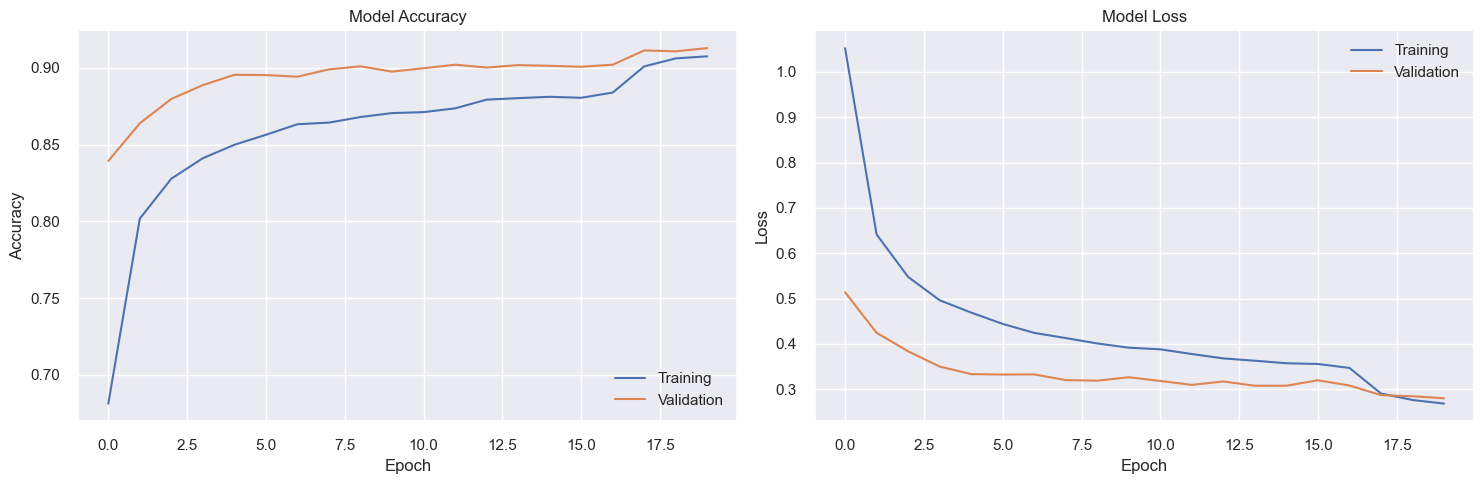

In [24]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/emnist_classifier.keras',
        save_best_only=True
    )
]

# Train model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()


463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.8992 - loss: 0.3227
Test accuracy: 0.8991
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


c:\Program Files\Orange\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


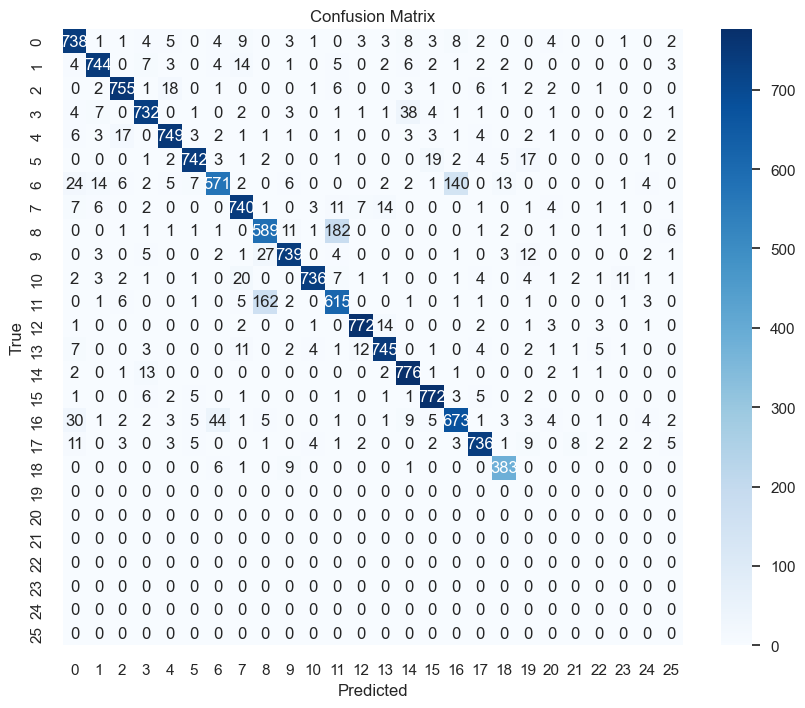

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Compute metrics
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')


# Plot confusion matrix
cm = tf.math.confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save metrics
metrics = {
    'model': 'emnist_classifier',
    'accuracy': float(test_accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.numpy().tolist()
}

# Save to file
with open('results/part_1/emnist_classifier_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']:.4f}\n")
    f.write(f"precision: {metrics['precision']:.4f}\n")
    f.write(f"recall: {metrics['recall']:.4f}\n")
    f.write(f"f1_score: {metrics['f1_score']:.4f}\n")
    f.write(f"confusion_matrix: {metrics['confusion_matrix']}\n")
    f.write("----\n")